### Importing all of the classification modules from pycaret. Important to note that prior to this I created a python environment in which I installed pycaret. I did not do it within the notebook because I have other libraries and dependencies I didn't want to mess with.

In [1]:
from pycaret.classification import *

### Importing additional libraries now that we need to complete some of the data organization.

In [2]:
import pandas as pd
import numpy as np

### Organizing Dataset -- Getting rid of variables that are not of interest and have far too many NA values, getting all points before 2008, Grabbing the subset of our data containing the 28 accounting variables of interest as well as the gvkey (unique for each firm) and the year of the observation

In [39]:
df = pd.read_csv("Documents/findata.csv")
df.head()
df.drop(labels=['sich', 'insbnk', 'understatement', 'option','p_aaer','new_p_aaer'], axis=1, inplace=True)
df.head()
dffin = df[df['Year'] < 2008]
dffin.head()
data = dffin.iloc[:, list((x for x in range(0,31)))]
data = data.dropna()
data.head()

,Year,gvkey,Fraud,Current Assets,Accounts Payable,Total Assets,Common Equity,Cash and Short-Term Investments,Cost of Goods Sold,Common Shares Outstanding,...,"Property, Plant, and Equipment",Preferred Stock,Retained Earnings,Receivables,Net Sales,Sale of Common and Preferred Stock,Income Taxes Payable,Total Income Taxes,Interest and Related Expense,"Price Close, Annual, Fiscal"
0,1990.0,1009.0,0.0,10.047,3.736,32.335,6.262,0.002,30.633,2.526,...,31.767,0.000,5.420,6.895,40.522,0.000,0.000,0.769,2.333,6.000
1,1990.0,1011.0,0.0,1.247,0.803,7.784,0.667,0.171,1.125,3.556,...,7.328,0.000,-3.339,0.290,3.635,0.006,0.000,0.000,0.640,1.188
2,1990.0,1017.0,0.0,55.040,3.601,118.120,44.393,3.132,107.343,3.882,...,78.331,0.000,46.630,47.366,144.258,0.000,0.000,0.986,3.962,5.125
3,1990.0,1021.0,0.0,24.684,3.948,34.591,7.751,0.411,31.214,4.755,...,11.145,1.295,3.280,8.522,48.292,0.000,0.448,0.365,2.269,1.562
4,1990.0,1028.0,0.0,17.325,3.520,27.542,-12.142,1.017,32.662,6.735,...,5.782,0.000,-25.955,6.354,33.543,0.000,0.000,0.000,3.510,1.125


### Generating one of our test datasets here. we will actually grab only the data past 2008 in an effort to further stress test our model and see how it peforms in a post '08 regulatory environment

In [30]:
df2 = pd.read_csv("Documents/findata.csv")
df2.head()
df2.drop(labels=['sich', 'insbnk', 'understatement', 'option','p_aaer','new_p_aaer'], axis=1, inplace=True)
df2.head()
dffin2 = df2[df2['Year'] >= 2008]
dffin2.head()
data_test_08 = dffin2.iloc[:, list((x for x in range(0,31)))]
data_test_08 = data_test_08.dropna()
data_test_08.head()

,Year,gvkey,Fraud,Current Assets,Accounts Payable,Total Assets,Common Equity,Cash and Short-Term Investments,Cost of Goods Sold,Common Shares Outstanding,...,"Property, Plant, and Equipment",Preferred Stock,Retained Earnings,Receivables,Net Sales,Sale of Common and Preferred Stock,Income Taxes Payable,Total Income Taxes,Interest and Related Expense,"Price Close, Annual, Fiscal"
107369,2008.0,1004.0,0.0,851.312,100.651,1377.511,656.895,112.505,1110.677,38.884,...,420.459,0.0,385.851,227.300,1423.976,0.599,6.482,39.309,18.371,14.70
107370,2008.0,1013.0,0.0,1077.400,99.100,1921.000,914.200,631.500,870.700,111.300,...,584.800,0.0,-505.600,240.600,1456.400,0.500,2.400,6.200,28.200,6.34
107371,2008.0,1021.0,0.0,12.686,3.557,21.401,4.177,0.819,19.334,17.929,...,2.252,0.0,-21.447,4.282,34.280,0.000,0.466,2.118,0.967,0.28
107372,2008.0,1045.0,0.0,5935.000,952.000,25175.000,-2935.000,3566.000,20232.000,278.949,...,26180.000,0.0,-6638.000,811.000,23766.000,295.000,0.000,0.000,756.000,10.67
107373,2008.0,1050.0,0.0,69.819,22.886,120.017,44.513,1.169,172.874,14.323,...,24.110,0.0,3.381,47.574,217.890,0.043,2.291,2.626,1.479,2.42


### Setting up Pycaret classification environment. Notice that we are stratiying our data in the based on target variable 'Fraud', as well as doing our fold strategy grouping by 'gvkey' which is a unique identifier for the company

In [47]:
s = setup(data, target = 'Fraud', normalize = True, data_split_stratify = True, fold_strategy = 'groupkfold', fold_groups = 'gvkey')

,Description,Value
0,session_id,7553
1,Target,Fraud
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(107369, 31)"
5,Missing Values,False
6,Numeric Features,30
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


### Instantiate the Multi Layer Perceptron Neural Network Model

In [48]:
mlp = create_model('mlp', probability_threshold = 0.25, hidden_layer_sizes = [2,32])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9928,0.6738,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9923,0.6445,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9916,0.7096,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.9922,0.8066,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.9936,0.6616,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.9915,0.7595,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.9904,0.7103,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.9937,0.6537,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.9925,0.7218,0.0000,0.0000,0.0000,0.0000,0.0000


### Checking the Paramters of our initial model just to get a feel for what the baseline looks like

In [49]:
print(mlp)

CustomProbabilityThresholdClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999,
                                     classifier=MLPClassifier(activation='relu',
                                                              alpha=0.0001,
                                                              batch_size='auto',
                                                              beta_1=0.9,
                                                              beta_2=0.999,
                                                              early_stopping=False,
                                                              epsilon=1e-08,
                                                              hidden_layer_sizes=[2,
                                                                                  32],
                                                              learning_rate='constant',
  

### Now we will begin hyperparamter tuning. Special attention paid to the fact that we are optimizing for precision. This was  a deliberate choice because we feel that limiting our number of false positives is important in this based on the business value of our model.

In [50]:
tuned = tune_model(mlp, n_iter = 10, optimize = 'Prec.')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9928,0.5913,0.0185,0.5000,0.0357,0.0352,0.0952
1,0.9923,0.7181,0.0862,0.5000,0.1471,0.1451,0.2053
2,0.9911,0.6538,0.0794,0.3571,0.1299,0.1272,0.1653
3,0.9916,0.7283,0.1017,0.3750,0.1600,0.1572,0.1922
4,0.9924,0.6165,0.1458,0.3043,0.1972,0.1938,0.2072
5,0.9912,0.7358,0.1094,0.4375,0.1750,0.1722,0.2156
6,0.9899,0.7020,0.0833,0.3750,0.1364,0.1333,0.1733
7,0.9927,0.5989,0.0213,0.1000,0.0351,0.0330,0.0434
8,0.9919,0.5897,0.0714,0.3077,0.1159,0.1135,0.1453


### Checking the Paramters of our tuned model so we know what all of the model paramters are explicitly

In [51]:
print(tuned)

MLPClassifier(activation='relu', alpha=1e-07, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[50, 50], learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=7553, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


### Attempting to optimize our probability threshold within the tuned model

In [52]:
 final_model = optimize_threshold(tuned, optimize = 'Prec.')   

### Checking the Paramters of our tuned model so we know what all of the model paramters are explicitly

In [61]:
print(final_model)

CustomProbabilityThresholdClassifier(activation='relu', alpha=1e-07,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999,
                                     classifier=MLPClassifier(activation='relu',
                                                              alpha=1e-07,
                                                              batch_size='auto',
                                                              beta_1=0.9,
                                                              beta_2=0.999,
                                                              early_stopping=False,
                                                              epsilon=1e-08,
                                                              hidden_layer_sizes=[50,
                                                                                  50],
                                                              learning_rate='adaptive',
   

In [62]:
save_model(final_model, 'final_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='Fraud',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strate...
                                                       epsilon=1e-08,
                                                       hidden_layer_sizes=[50,
                                                                           50],
                                             

### Using our model to test its prediction capabilities on our test set that was automatically held out by pycaret setup function.

In [63]:
test_prediction = predict_model(final_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,MLP Classifier,0.9917,0.7233,0.0484,0.2727,0.0822,0.0801,0.1121


### Using our model to test its prediction capabilities on our test set of data after 2008 to see how we perform in the new age regulatory environment.

In [64]:
test_08_prediction = predict_model(final_model, data = data_test_08)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,MLP Classifier,0.9957,0.4772,0.0000,0.0000,0.0000,-0.0013,-0.0017


### Using our model to test its prediction capabilites on our contemporary set of 2020-2021 data.

### Confusion Matrix of our base model just to see what predictions it made

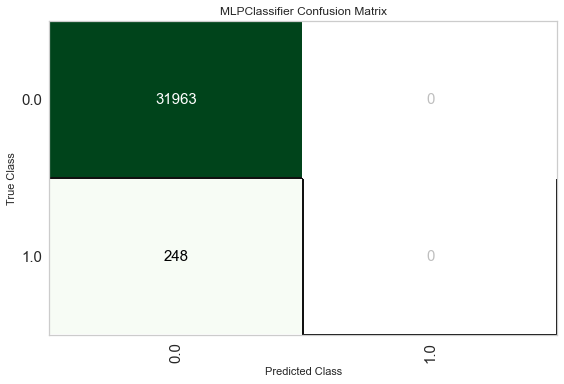

In [65]:
plot_model(mlp, plot = 'confusion_matrix')

### Confusion Matrix of our tuned model to see the improvement in the raw numbers of our predictions

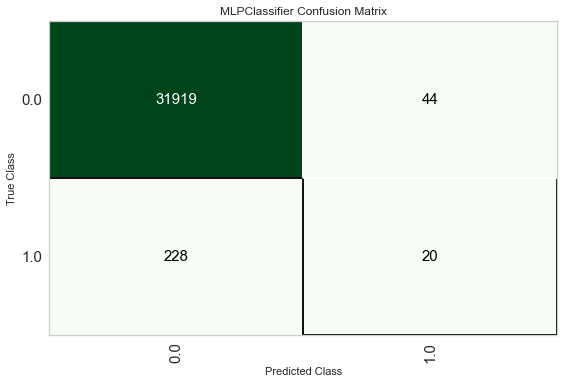

In [66]:
plot_model(tuned, plot = 'confusion_matrix')

### Confusion Matrix of our final model to see the improvement in the raw numbers of our predictions

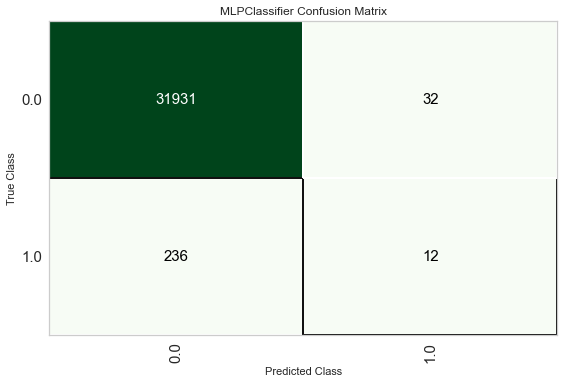

In [67]:
plot_model(final_model, plot = 'confusion_matrix')

### Gain chart of our base model

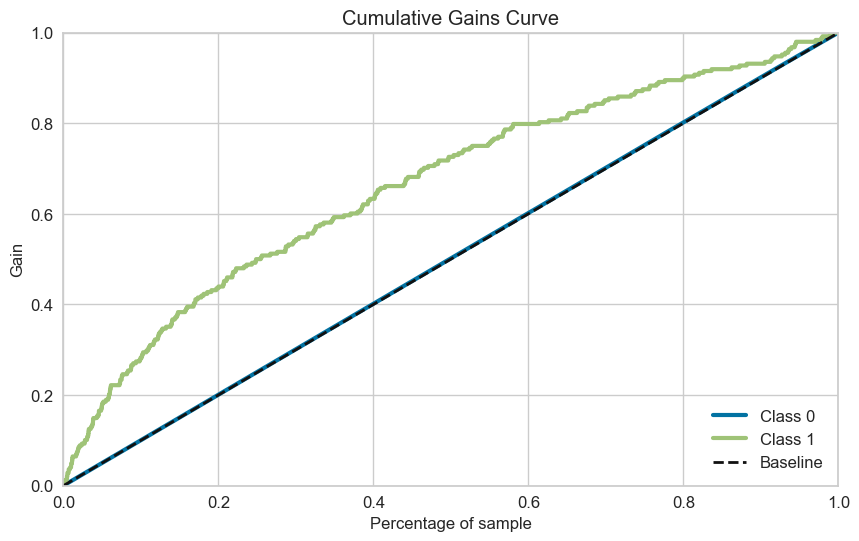

In [55]:
plot_model(mlp, plot = 'gain')

### Gain chart of our tuned model

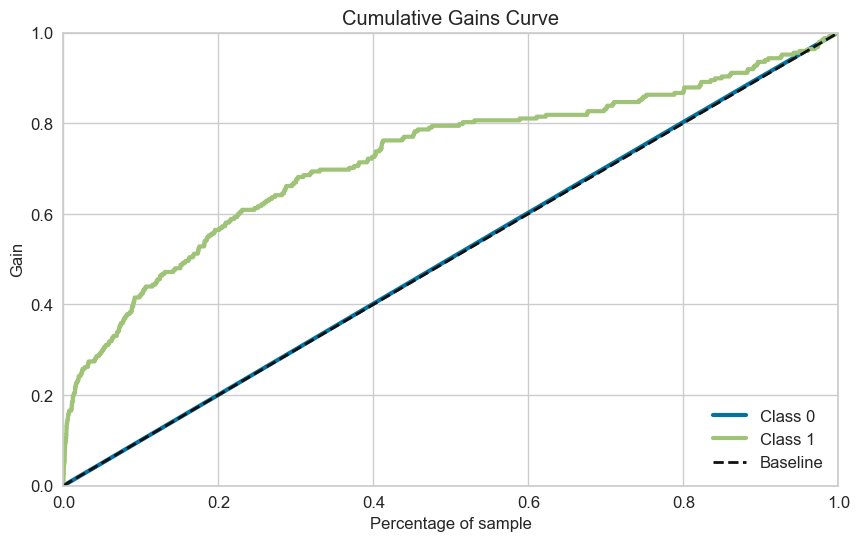

In [56]:
plot_model(tuned, plot = 'gain')

### Gain chart of our final model

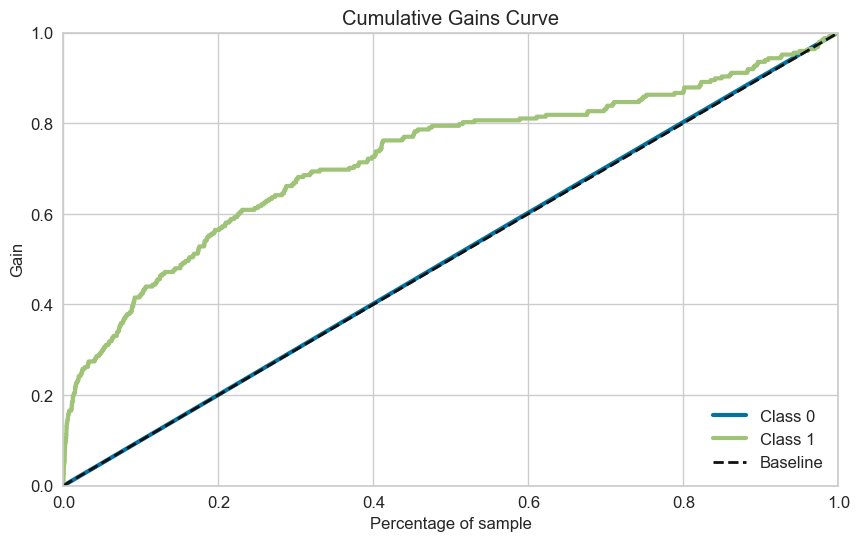

In [58]:
plot_model(final_model, plot = 'gain')

### ROC Area Under Curve plots for base model

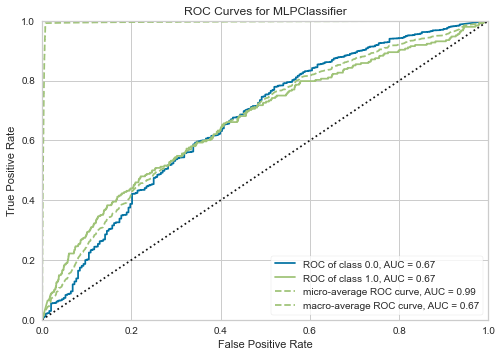

In [57]:
plot_model(mlp, plot = 'auc')

### ROC Area Under Curve plots for tuned model

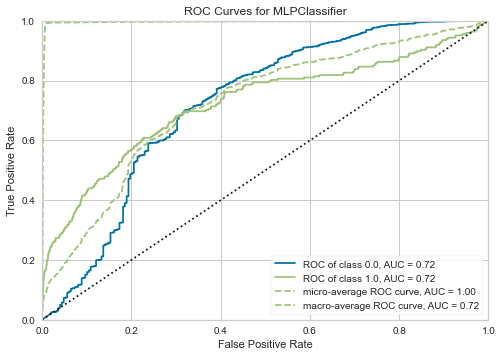

In [59]:
plot_model(tuned, plot = 'auc')

### ROC Area Under Curve plots for final model

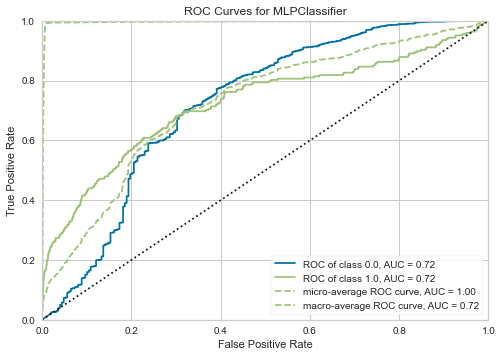

In [60]:
plot_model(final_model, plot = 'auc')